# Kaggle Competition:
Predict the House Prices using advanced regression techniques





# Import Required Packages

---



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Random Forest packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,make_scorer
from sklearn.model_selection import cross_val_score
from sklearn import metrics

Import google drive library to load csv files:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content/drive/My Drive/Colab_Notebooks/Kaggle/Price_Prediction


Change path directory to redirect to data folder:

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/Kaggle/Price_Prediction
!ls data

/content/drive/MyDrive/Colab_Notebooks/Kaggle/Price_Prediction
test.csv  train.csv


# Read datasets - train.csv and test.csv
Datasets will be read from **google drive** path.
Data path is set to '/MyDrive/Colab_Notebooks/Kaggle/Price_Prediction/data/'
---



In [ ]:
#data_path = '/MyDrive/Colab_Notebooks/Kaggle/Price_Prediction/data/'

In [ ]:
# Read train.csv and test.csv
train_df = pd.read_csv( 'data/train.csv');
test_df = pd.read_csv('data/test.csv');

In [ ]:
#print(train_df.describe())
#print(test_df.describe())

# Correlation and Heatmap

---



In [ ]:
corrMat = train_df.corr()
#corrMat

Text(0.5, 1.0, 'Correlation Matrix')

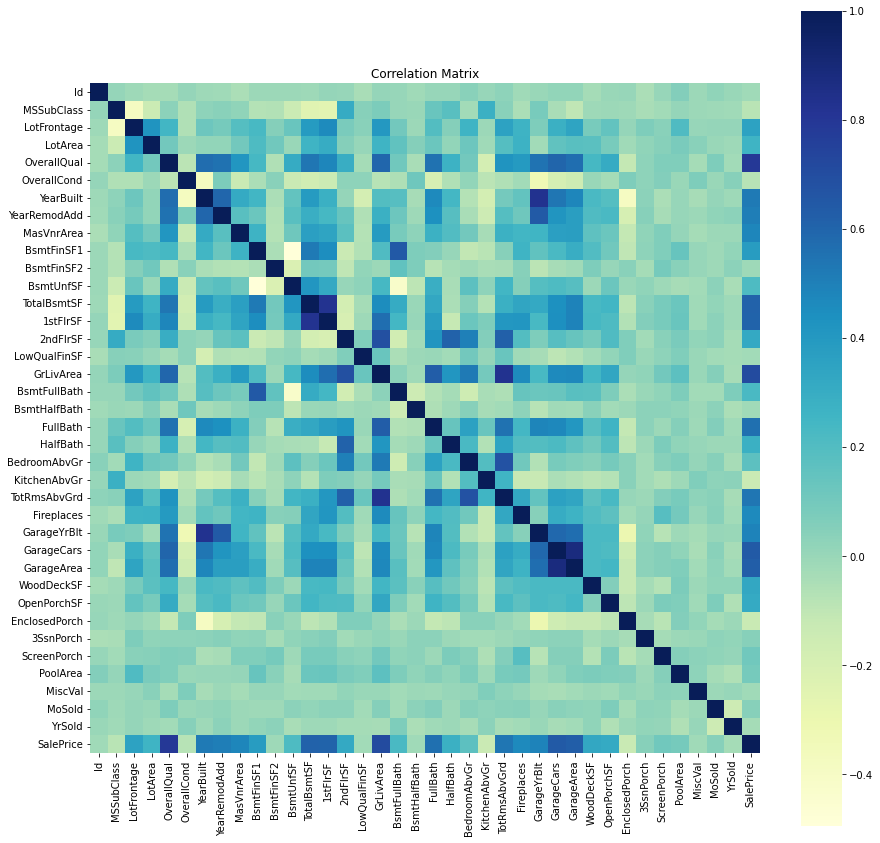

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(corrMat, vmax=1,square=True, cmap="YlGnBu")
plt.title("Correlation Matrix")

# Preprocess train.csv

---



## Imputing Missing Values in train.csv


In [ ]:
# Replacing NA values in LotFrontage column with the mean value of the column data
meanValueLF = np.round(train_df['LotFrontage'].mean(), 2)
train_df['LotFrontage'].fillna(meanValueLF, inplace = True);

# Replace Alley column value NA with Unknown
train_df['Alley'] = train_df['Alley'].replace(np.nan, 'Unknown')

# Imputing NA values in MasVnrArea column with mode value
train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].mode(), inplace = True)
train_df['MasVnrArea'] = train_df['MasVnrArea'].replace(np.nan, 0)

# Dropping rows with NA values in GarageYrBlt
train_df.dropna(subset=['GarageYrBlt'], inplace = True)

#train_df_x.to_csv('testaru.csv')

## Change "object" categorical columns into numerical categorical columns in train.csv


In [ ]:
trainObjCol = list(train_df.select_dtypes(include=['object']).columns)
for c in trainObjCol:
  train_df[c] = train_df[c].astype('category').cat.codes

## Dividing training dataset into x and y

---



In [ ]:
# divide train data in x and y
train_df_y = train_df['SalePrice']
train_df_x = train_df.drop('SalePrice', axis=1)

In [ ]:
# Drop the ID column
train_df_x.drop('Id', axis = 1, inplace = True)

## Applying standard scaler on train.csv

In [ ]:
scalar = StandardScaler()
train_df_X = scalar.fit_transform(train_df_x)

# Preprocess test.csv

---



## Imputing Missing Values in Test dataset

In [ ]:
# Replacing NA values in LotFrontage column with the mean value of the column data
meanValueLFtest = np.round(test_df['LotFrontage'].mean(), 2)
test_df['LotFrontage'].fillna(meanValueLFtest, inplace = True);

# Replace Alley column value NA with Unknown
test_df['Alley'] = test_df['Alley'].replace(np.nan, 'Unknown')

# Imputing NA values in MasVnrArea column with mode value
test_df['MasVnrArea'].fillna(test_df['MasVnrArea'].mode(), inplace = True)
test_df['MasVnrArea'] = test_df['MasVnrArea'].replace(np.nan, 0)

# Dropping rows with NA values in GarageYrBlt
test_df.dropna(subset=['GarageYrBlt'], inplace = True)

## Change "object" categorical columns into numerical categorical columns in test.csv

In [ ]:
testObjCol = list(test_df.select_dtypes(include=['object']).columns)
for c in testObjCol:
  test_df[c] = test_df[c].astype('category').cat.codes

In [ ]:
mask = test_df.isnull()
nan_records = test_df.loc[mask.any(axis=1), mask.any(axis=0)]
nan_columns = nan_records.columns
nan_columns

Index(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath'],
      dtype='object')

In [ ]:
for c in nan_columns:
  test_df[c] = test_df[c].replace(np.nan, 0)

In [ ]:
# Capture the ID column from test dataset into a separate dataframe
test_id = pd.DataFrame(test_df['Id'])
# Drop the ID column
test_df.drop('Id', axis = 1, inplace = True)

## Applying standard scaler on test.csv

In [ ]:
scalar = StandardScaler()
test_df_X = scalar.fit_transform(test_df)

# Principle Component Analysis

---
train_df_X is the scaled dataset having 79 original features.


In [ ]:
pca=PCA()
pca_org = pca.fit_transform(train_df_X)
pca_cv = pca.get_covariance()
explained_variance=pca.explained_variance_ratio_

Plotting explained variance from PCA:

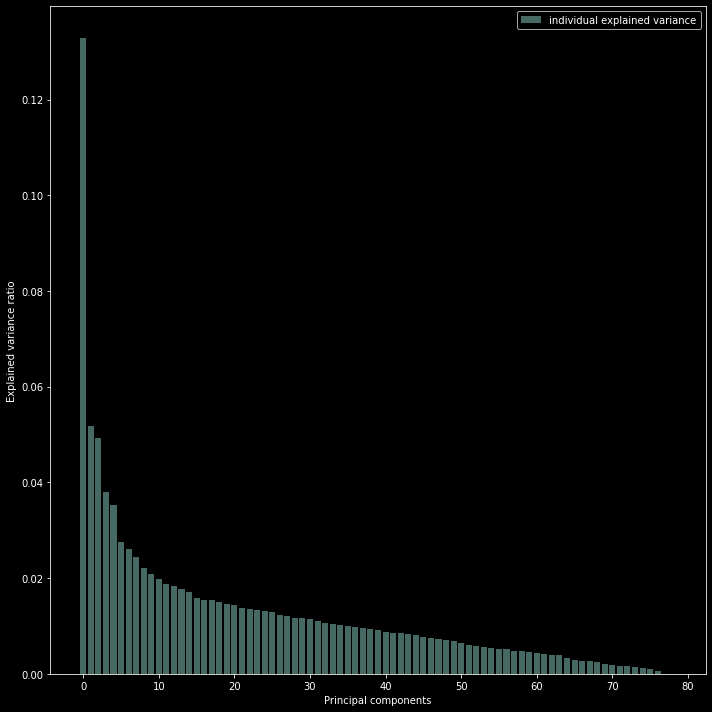

In [ ]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(10, 10))
    plt.bar(range(79),explained_variance, alpha=0.5,align='center', label='individual explained variance' )
    plt.xlabel('Principal components')
    plt.ylabel('Explained variance ratio')
    plt.legend()
    plt.tight_layout()

    # range(79) used because number of features in the data is 79

Selecting principle components that explains 95% of variance in data.

In [ ]:
cumulative_variance_ratio = np.cumsum(explained_variance)
num_components = np.argmax(cumulative_variance_ratio > 0.95) + 1
print("{} number of components which explaons 95% of variance in data.".format( num_components))

59 number of components which explaons 95% of variance in data.


In [ ]:
loadings = pca.components_
loadings_df = pd.DataFrame(loadings.T, columns=pd.DataFrame(train_df_X).columns)
#print(loadings_df)
feature_list = []
for i in range(num_components):
    top_features = list(loadings_df.iloc[:, i].abs().sort_values(ascending=False).index[:2])
    #print('Top 5 features for PC{}: {}'.format(i+1, top_features.tolist()))
    for i in top_features:
      feature_list.append(i)
    #print(list(top_features))

The variable **final_features** contain the number of features to be considered for modeling.

In [ ]:
final_features = list(set(feature_list))
print("{} features from the original dataset will be used for modeling.".format(len(final_features)))

62 features from the original dataset will be used for modeling.


Using number of components from previous step to transform the original features and plot the explained variance.

In [ ]:
pca_n=PCA(n_components=num_components)
pca_new = pca_n.fit_transform(train_df_X)
pca_n_cv = pca_n.get_covariance()
explained_variance_new=pca_n.explained_variance_ratio_

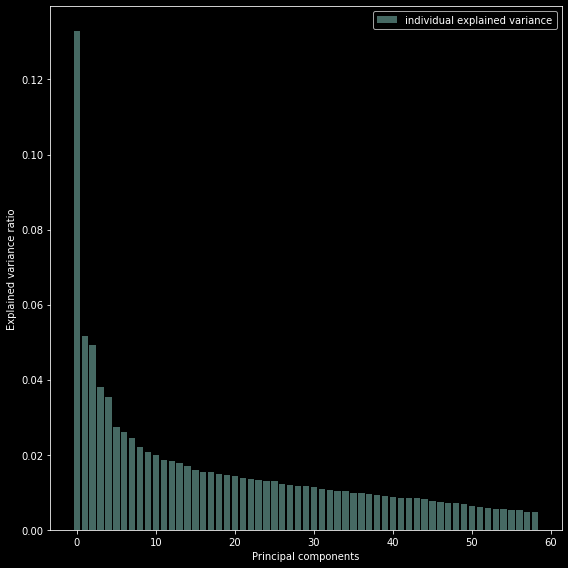

In [ ]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(8, 8))
    plt.bar(range(num_components),explained_variance_new, alpha=0.5,align='center', label='individual explained variance' )
    plt.xlabel('Principal components')
    plt.ylabel('Explained variance ratio')
    plt.legend()
    plt.tight_layout()

# Data Modeling

In [ ]:
train_sel = train_df_X[:,final_features]
test_sel = test_df_X[:,final_features]

Since **test.csv** does not contain the target variable, below steps are performed to proceed with the modeling:

*   The train dataset will be split for training and predicting pupose.
*   This will be done to find the RMSE value of the model.
*   The model will be used to predict the value from initial test data.






In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_sel, train_df_y, test_size=0.3, random_state=42, shuffle = True)

## Random Forest

### without Cross Validation

Executing a for loop to determine the value of max_depth parameter that gives the lowest RMSE value.

In [ ]:
# Creating random forest clasifier object
RMSE = 0; md = 0; mae = 0; mse = 0
for i in range(100):
  rf = RandomForestRegressor(n_estimators=100, max_depth=(i+1), random_state=42)
  rf.fit(X_train, y_train)
  Y_pred = rf.predict(X_test)
  rval =  np.sqrt(metrics.mean_squared_error(y_test, Y_pred))
  if (i+1) == 1:
    RMSE = rval
  elif rval < RMSE:
    RMSE = rval
    md = i+1
    mae  = metrics.mean_absolute_error(y_test, Y_pred)
    mse = metrics.mean_squared_error(y_test, Y_pred)


# Evaluation
print("The RMSE value is {} for max_depth {} of the Random Forest model.".format( RMSE,md))
print('Mean Absolute Error:', mae)  
print('Mean Squared Error:', mse)  

The RMSE value is 33498.235212110114 for max_depth 17 of the Random Forest model.
Mean Absolute Error: 21490.634205554958
Mean Squared Error: 1122131762.3258538


Re-training the model with max_depth = 17 obtained from previous step and predicting the y value from test dataset.

In [ ]:
rf_new = RandomForestRegressor(n_estimators=100, max_depth=md, random_state=42)
rf.fit(train_sel, train_df_y)
Y_pred_new = rf.predict(test_sel)

In [ ]:
final_df = pd.DataFrame(columns={'ID':int, 'Predicted_Sales_Price':float})
#test_id = test_id.reset_index()
id = 0
for i in range(len(test_sel)):
  id = test_id['Id'][i]
  final_df = final_df.append({'ID': id, 'Predicted_Sales_Price': Y_pred_new[i]}, ignore_index=True)
final_df['ID'] = final_df['ID'].astype(int)

In [ ]:
final_df

,ID,Predicted_Sales_Price
0,1461,145797.09
1,1462,180998.92
2,1463,159790.07
3,1464,186849.54
4,1465,192784.56
...,...,...
1376,2912,158175.22
1377,2913,94719.70
1378,2916,95648.21
1379,2917,170959.09
